# Modeling

In [84]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder,LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import umap
from dash import dcc, html, Input, Output
import plotly.express as px
from plotly import colors
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings("ignore")

After preprocessing the data, we obtained a clean dataset ready for analysis. To focus on the descriptive attributes of each artifact, we performed dimensionality reduction on three key columns: `subject_Clean_other_mapped`, `resource_Clean_other_mapped`, and `Languages_Clean_other_mapped`. These columns were transformed using one-hot encoding, resulting in 87 distinct features. 

We then applied DBSCAN, a density-based clustering algorithm, to identify meaningful patterns in the data. Each resulting cluster was analyzed to determine the predominant attributes across the three original columns, providing a basis for understanding the composition and characteristics of the clustered data.

To visualize the results, we created clear and intuitive charts to highlight the clustering outcomes and the dominant descriptive features within each cluster. These model revealed how specific subjects, resources, and language attributes influenced cluster formation, offering insights into the relationships and patterns present in the data. This approach facilitated a deeper understanding of the dataset’s structure and key themes.

In [85]:
# Load the dataset
df = pd.read_csv('final_df.csv')

df=df[(df.country!='United States')&(~df.country.isna())].sample(n=10000)

In [87]:
df.shape

(10000, 23)

In [79]:
df['library_city']=df.library_call_number.apply(lambda x: x.split(',')[0])

In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

# Function to process MultiLabelBinarizer for specified columns
def process_multilabel_columns(df, columns):
    label_encoded_X = []
    mlb_list = []
    
    for col in columns:
        mlb = MultiLabelBinarizer()
        # Convert column values to lists if not already
        column_data = df[col].apply(lambda x: x if isinstance(x, list) else ([] if pd.isnull(x) else [x]))
        label_encoded = mlb.fit_transform(column_data)
        label_encoded_X.append(label_encoded)
        mlb_list.append(mlb)
        
    return np.hstack(label_encoded_X), mlb_list

# Multi-label encoding
multi_label_columns = ['subject_Clean_other_mapped', 'resource_Clean_other_mapped', 'Languages_Clean_other_mapped']
X_combined, mlb_list = process_multilabel_columns(df, multi_label_columns)

# Process categorical column
categorical_data = df[['country', 'library_city']].fillna('Unknown').astype(str).values  # Ensure proper data type for encoding

# Create the encoder
label_encoder = LabelEncoder()

# Fit and transform each categorical column separately and combine
encoded_labels = np.hstack([
    label_encoder.fit_transform(categorical_data[:, i]).reshape(-1, 1)
    for i in range(categorical_data.shape[1])
])

# Combine multi-label encoded data with encoded categorical features
X_combined = np.hstack((X_combined, encoded_labels))

# Resulting data
print("Shape of combined feature matrix:", X_combined.shape)


Shape of combined feature matrix: (10000, 91)


In [83]:
# UMAP dimensionality reduction
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_combined)  # Use a subset for visualization

In [ ]:
# Apply DBSCAN clustering
dbscan = DBSCAN( eps=0.5, min_samples=100)
# Add UMAP results to the DataFrame
umap_df = pd.DataFrame(X_umap, columns=['UMAP 1', 'UMAP 2'])
umap_df['index'] = df.index
umap_df['DBSCAN_Cluster'] = dbscan.fit_predict(umap_df[['UMAP 1', 'UMAP 2']])
    

In [ ]:

# Merge and process DataFrame
umap_df = umap_df.merge(df, left_on='index', right_index=True)
umap_df['found_date'] = pd.to_datetime(umap_df['found_date'], format='%Y', errors='coerce')
umap_df = umap_df.dropna(subset=['found_date'])

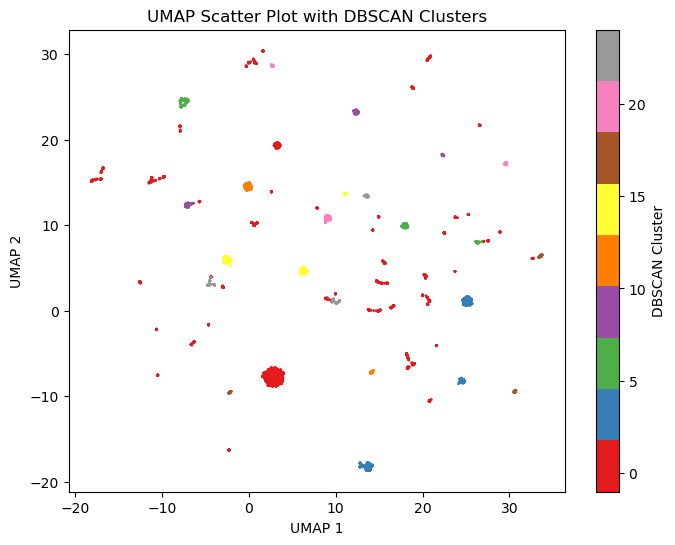

In [76]:
# Assuming `umap_df` is your DataFrame with columns 'UMAP 1', 'UMAP 2', and 'DBSCAN_Cluster'

# Scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    umap_df['UMAP 1'], 
    umap_df['UMAP 2'], 
    s=1, 
    c=umap_df['DBSCAN_Cluster'],  # 'c' is used for color, not 'color'
    cmap='Set1'  # You can choose a colormap or remove it for default coloring
)

# Add colorbar if needed
plt.colorbar(scatter, label='DBSCAN Cluster')

# Add labels and title
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP Scatter Plot with DBSCAN Clusters')

# Show plot
plt.show()


In [18]:
import dash
import dash_html_components as html

In [29]:

# Create a larger discrete color scale
color_scale = colors.qualitative.Dark24+colors.qualitative.Light24+colors.qualitative.Bold
def summarize_cluster(group):
    return {
        'Languages': group['Languages_Clean_other_mapped'].mode()[0] if not group['Languages_Clean_other_mapped'].mode().empty else 'Unknown',
        'Subject': group['subject_Clean_other_mapped'].mode()[0] if not group['subject_Clean_other_mapped'].mode().empty else 'Unknown',
        'Resource': group['resource_Clean_other_mapped'].mode()[0] if not group['resource_Clean_other_mapped'].mode().empty else 'Unknown'
    }
# # Summarize cluster attributes (from previous steps)
cluster_summaries = (
    umap_df.groupby('DBSCAN_Cluster')
    .apply(summarize_cluster)
    .apply(pd.Series)
)

cluster_summaries['Cluster Name'] = (
    'Lang: ' + cluster_summaries['Languages'] +
    ', Subj: ' + cluster_summaries['Subject'] +
    ', Res: ' + cluster_summaries['Resource']
)

# cluster_name_map = cluster_summaries['Cluster Name'].to_dict()
#umap_df['Cluster Name'] = umap_df['DBSCAN_Cluster'].map(cluster_name_map)
umap_df.loc[umap_df['DBSCAN_Cluster'] == -1, 'Cluster Name'] = 'Unclustered'

# Create initial scatter plot
fig = px.scatter(
    umap_df,
    x='UMAP 1',
    y='UMAP 2',
    color='Cluster Name',
    color_discrete_sequence=color_scale,
    title="UMAP Dimensionality Reduction with Cluster Names",
    hover_data={
        'UMAP 1': True,
        'UMAP 2': True,
        'DBSCAN_Cluster': True,
        'Languages_Clean_other_mapped': True,
        'subject_Clean_other_mapped': True,
        'resource_Clean_other_mapped': True
    },
    labels={'color': 'Cluster Label'}
)

fig.update_layout(
    legend=dict(
        orientation="v",  # Vertical orientation for better scrolling
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.02,  # Position the legend outside the plot
        font=dict(
            size=5  # Adjust font size
        ),
        traceorder="normal",  # Keep the order as is
        title=dict(text="Cluster Labels"),  # Optional: Add a legend title
        itemclick="toggle",  # Allow toggling traces by clicking legend items
        itemdoubleclick="toggleothers",  # Double-click behavior
    ),
    margin=dict(r=200),  # Add margin to accommodate the legend
)

# Add a fixed height to allow scrolling in the legend
fig.update_layout(
    legend=dict(
        itemsizing="constant",
        valign="top",
    ),
   
)



# Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id='umap-plot',
        figure=fig
    ),
    html.Div(id='cluster-info', style={'padding': '20px', 'font-size': '18px'})
])

# Callback to display cluster information
@app.callback(
    Output('cluster-info', 'children'),
    Input('umap-plot', 'clickData')
)
def display_cluster_info(click_data):
    if click_data is None:
        return "Click on a cluster point to view detailed information."

    # Extract cluster name from clicked point
    cluster_name = click_data['points'][0]['customdata'][-1]  # Assuming 'Cluster Name' is the last hover data field
    cluster_id = click_data['points'][0]['customdata'][2]  # Assuming 'DBSCAN_Cluster' is the 3rd hover data field

    # Retrieve detailed information about the cluster
    cluster_details = cluster_summaries.loc[cluster_id]

    # Format cluster information for display
    details = f"""
    **Cluster Name:** {cluster_name}
    - Dominant Language: {cluster_details['Languages']}
    - Dominant Subject: {cluster_details['Subject']}
    - Dominant Resource: {cluster_details['Resource']}
    """
    return details

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


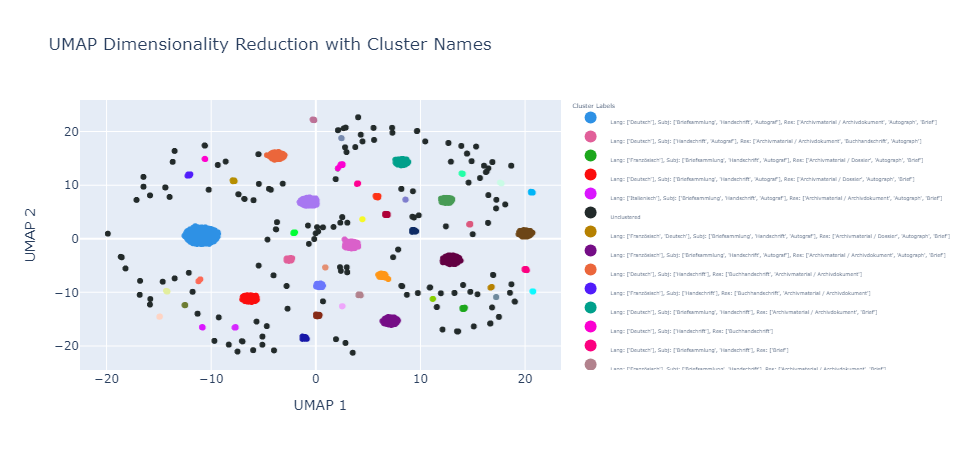

## Results: 

Our final implementation yielded 47 clusters, with one unclustered group serving as noise, while the remaining clusters exhibited cohesive groupings based on the most similar values across the three descriptive columns. Each cluster highlighted distinct patterns in the data, driven by shared attributes in `Languages_Clean_other_mapped`, `subject_Clean_other_mapped`, and `resource_Clean_other_mapped`.

For instance, Cluster 0 consistently contained artifacts described as **Language: ['Deutsch']**, **Subjects: ['Briefsammlung', 'Handschrift', 'Autograf']**, and **Resources: ['Archivmaterial / Archivdokument', 'Autograph', 'Brief']**. These shared attributes suggest potential for further exploration. Users could investigate the years of publication, geographical locations, and delve into the documents themselves for deeper study.

Visualizations were developed to showcase these clustering results, with each cluster's dominant attributes clearly highlighted. These insights provide a foundation for targeted analysis, enabling users to explore specific trends, contexts, or historical nuances embedded within the clustered data. This approach not only organizes the dataset but also opens new avenues for research and discovery.

In [ ]:
#umap_df[umap_df['DBSCAN_Cluster']==0]['Cluster Name'][0]

In [ ]:
# umap_df['title']=umap_df['title'].apply(lambda x: x.replace('\"', '').replace('\'', ''))
# umap_df['series']=umap_df['series'].apply(lambda x: x.replace('\"', '').replace('\'', ''))
# umap_df[['UMAP 1', 'UMAP 2', 'index', 'DBSCAN_Cluster', 'series',
#        'identifier_swisscollections', 'subject_form', 'library_call_number',
#         'date_of_publication_or_production_standardised',
#         'physical_description',  'title','Cluster Name',
#        'found_date', 'Languages_Clean_other_mapped',
#        'subject_Clean_other_mapped',
#        'resource_Clean_other_mapped' , 'lat', 'lng', 'Cluster Color', 'city']].to_csv('final_umap_included.csv')

# Reflection on Data Wrangling and Modeling Decisions

Our data wrangling and modeling pipeline successfully supports the visualization and exploration tasks of the "FacetForge" application. Preprocessing steps, such as one-hot encoding of categorical attributes and mapping inconsistencies, provided a robust foundation for dimensionality reduction using UMAP and clustering with DBSCAN. This approach effectively addressed the complexity and noise in the dataset, yielding clusters with coherent patterns.


The model supports key tasks like filtering, identifying, and discovering relationships between dimensionality reduction and document attributes. Clusters reveal dominant languages, resource types, and subject forms, aligning well with the goal of interactive exploration. Additionally, preprocessing ensured that inconsistencies, especially in attributes like dates and locations, were minimized, improving data reliability.

## Refinements: 
- Inconsistent and missing values in the date_of_publication_or_production_standardised attribute could be addressed more comprehensively. Currently we are retrieving only one column based on it, but we can get also the production standardised date as well. 
- To ensure the models align with user needs, implementing interactive machine learning (IML) techniques would be highly beneficial. Users could iteratively provide feedback on clustering results, relevance of dimensions, and attribute importance. This feedback loop would allow real-time adjustments to clustering parameters (e.g., DBSCAN’s epsilon or attribute weights), ensuring clusters better reflect the dataset’s nuanced patterns.

- Attributes like language, subject_form, and resource_type may vary in their importance across different tasks. Using the domain knowledge, applying weighted clustering, where more influential attributes are given higher significance, could yield more insightful clusters.

- The unclustered "noise" group might contain documents with unique or rare combinations of attributes. A deeper analysis of this group could reveal underrepresented trends or anomalies, offering new research directions.

- For user-friendly exploration, integrating dynamic visualization tools hierarchical cluster views could offer more intuitive insights. Highlighting transitions would also improve the interpretability of relationships.


